# Loading the Data

In [57]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
import shap
import cfbd
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

In [58]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [59]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower().replace('t_ds', 'tds'))
    return cols_new

In [60]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in range(2012, 2025): # Adjusted to include 2012 for rolling window
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp = tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp = tmp.assign(
            home_division=tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        tmp = tmp[id_cols + home_cols + away_cols]
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
games.head()

Reading ../data/games/2012.parquet from cached data
Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo,start_date
0,322432710,2012,1,regular,True,False,3746.0,2710,Western Illinois,MVFC,fcs,23.0,NaN,2086,Butler,Pioneer,fcs,15.0,NaN,NaT
1,322432117,2012,1,regular,True,False,3786.0,2117,Central Michigan,Mid-American,fbs,38.0,NaN,2546,Southeast Missouri State,OVC,fcs,27.0,NaN,NaT
2,322432050,2012,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,37.0,1299.0,2199,Eastern Michigan,Mid-American,fbs,26.0,1231.0,NaT
3,322432006,2012,1,regular,True,False,3768.0,2006,Akron,Mid-American,fbs,14.0,997.0,2116,UCF,Conference USA,fbs,56.0,1559.0,NaT
4,322430238,2012,1,regular,True,False,3973.0,238,Vanderbilt,SEC,fbs,13.0,1573.0,2579,South Carolina,SEC,fbs,17.0,1743.0,NaT


In [61]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            tmp.columns = convert_to_snake_case(tmp.columns)

            tmp['clock_minutes'] = tmp['clock'].apply(lambda x: x['minutes'])
            tmp['clock_seconds'] = tmp['clock'].apply(lambda x: x['seconds'])
            tmp.drop(columns=['clock'], inplace=True)

            tmp = tmp[cols]
            season_dfs.append(tmp)
        
        season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, tmp

    all_dfs.append(season_plays)

    del season_plays
    
plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0


In [62]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
elo = pd.concat(elos, ignore_index=True).reset_index(drop=True)
elo = elo.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
elo.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


In [63]:
game_team_stats_dir = join(DATA_DIR, 'game_team_stats')
if not os.path.exists(game_team_stats_dir):
    os.makedirs(game_team_stats_dir)

def flatten_team_data(row):
    game_id = row['id']
    teams_data = row['teams']
    
    # Parse the JSON string if it's not already parsed
    if isinstance(teams_data, str):
        teams_data = json.loads(teams_data)
    
    rows = []
    for team in teams_data:
        # Create base dictionary with non-stats fields
        team_row = {
            'game_id': game_id,
            'teamId': team['teamId'],
            'team': team['team'],
            'conference': team['conference'],
            'homeAway': team['homeAway'],
            'points': team['points']
        }
        
        # Add stats fields
        for stat in team['stats']:
            # Convert stat names to valid column names if needed
            col_name = stat['category']
            team_row[col_name] = stat['stat']
        
        rows.append(team_row)
    
    return rows

all_dfs = []
for year in range(2012, 2025): # Include year prior to 2013 for rolling stats
    file_path = join(DATA_DIR, 'game_team_stats', f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
        all_dfs.append(tmp)
    else:
        weeks = games.query('season == @year').week.unique().tolist()
        if not weeks:
            weeks = range(1, 16)

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} team stats data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.GamesApi(api_client)
                data = api_instance.get_game_team_stats(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                games_count = games.query('season == @year and week == @week and home_division == "fbs"').shape[0] + \
                    games.query('season == @year and week == @week and away_division == "fbs"').shape[0]
                print(f'No team stats data for {year} week {week}, number of FBS teams: {games_count}')
                continue

            flattened_data = []
            for _, row in tmp.iterrows():
                flattened_data.extend(flatten_team_data(row))
            result_df = pd.DataFrame(flattened_data)

            base_columns = ['game_id', 'teamId', 'team', 'conference', 'homeAway', 'points']
            stat_columns = [col for col in result_df.columns if col not in base_columns]
            result_df = result_df[base_columns + stat_columns]
            result_df.columns = convert_to_snake_case(result_df.columns)
            season_dfs.append(result_df)

        season_df = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)

        all_dfs.append(season_df)
        season_df.to_parquet(file_path)

team_stats = (
    games[['id', 'season', 'week', 'season_type']].rename(columns={'id': 'game_id'})
    .merge(
        pd.concat(all_dfs, ignore_index=True).reset_index(drop=True),
        on='game_id', how='left'
    )
    .dropna(subset=['team_id'])
    .sort_values(
        by=['season', 'season_type', 'week', 'team_id'], 
        ignore_index=True, 
        ascending=[True, False, True, True]
    )
)
team_stats.head()

Reading ../data/game_team_stats/2012.parquet from cached data
Reading ../data/game_team_stats/2013.parquet from cached data
Reading ../data/game_team_stats/2014.parquet from cached data
Reading ../data/game_team_stats/2015.parquet from cached data
Reading ../data/game_team_stats/2016.parquet from cached data
Reading ../data/game_team_stats/2017.parquet from cached data
Reading ../data/game_team_stats/2018.parquet from cached data
Reading ../data/game_team_stats/2019.parquet from cached data
Reading ../data/game_team_stats/2020.parquet from cached data
Reading ../data/game_team_stats/2021.parquet from cached data
Reading ../data/game_team_stats/2022.parquet from cached data
Reading ../data/game_team_stats/2023.parquet from cached data
Reading ../data/game_team_stats/2024.parquet from cached data


,game_id,season,week,season_type,team_id,team,conference,home_away,points,possession_time,interceptions,fumbles_lost,turnovers,total_penalties_yards,yards_per_rush_attempt,rushing_attempts,rushing_yards,yards_per_pass,completion_attempts,net_passing_yards,total_yards,fourth_down_eff,third_down_eff,first_downs,passes_intercepted,interception_t_ds,interception_yards,kicking_points,kick_returns,kick_return_t_ds,kick_return_yards,passing_t_ds,punt_returns,punt_return_t_ds,punt_return_yards,rushing_t_ds,fumbles_recovered,kick_return_tds,passing_tds,rushing_tds,interception_tds,punt_return_tds,passes_deflected,qb_hurries,sacks,tackles,defensive_tds,tackles_for_loss,total_fumbles
0,322450002,2012,1,regular,2.0,Auburn,SEC,home,19.0,28:14,1,1,2,6-38,4.9,37,180,7.2,11-27,194,374,0-1,4-13,17,1,0,12,13,1,0,21,1,1,0,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,322450005,2012,1,regular,5.0,UAB,Conference USA,home,29.0,41:39,1,3,4,9-47,3.0,44,134,9.6,19-34,325,459,0-2,8-16,23,None,None,None,5,5,0,82,2,3,0,-6,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,322450006,2012,1,regular,6.0,South Alabama,Sun Belt,home,31.0,26:53,1,3,4,7-80,3.4,37,126,7.0,15-26,182,308,2-2,5-13,18,1,0,28,7,2,0,95,2,2,0,37,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,322450008,2012,1,regular,8.0,Arkansas,SEC,home,49.0,25:41,0,3,3,6-38,4.7,35,164,11.8,23-34,400,564,0-2,5-9,25,None,None,None,7,4,0,96,3,5,0,29,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,322430009,2012,1,regular,9.0,Arizona State,Pac-12,home,63.0,30:16,0,1,1,4-30,6.0,51,305,12.4,16-20,249,554,1-1,7-13,25,3,1,117,9,1,0,7,1,2,0,13,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
advanced_team_stats_dir = join(DATA_DIR, 'advanced_team_stats')
if not os.path.exists(advanced_team_stats_dir):
    os.makedirs(advanced_team_stats_dir)

def parse_stats(row):
    offense = row['offense']
    return pd.Series({
        'offense_ppa': offense.get('ppa'),
        'offense_successRate': offense.get('successRate'),
        'offense_explosiveness': offense.get('explosiveness'),
        'offense_passingPlays_ppa': offense.get('passingPlays', {}).get('ppa'),
        'offense_passingPlays_successRate': offense.get('passingPlays', {}).get('successRate'),
        'offense_passingPlays_explosiveness': offense.get('passingPlays', {}).get('explosiveness'),
        'offense_rushingPlays_ppa': offense.get('rushingPlays', {}).get('ppa'),
        'offense_rushingPlays_successRate': offense.get('rushingPlays', {}).get('successRate'),
        'offense_rushingPlays_explosiveness': offense.get('rushingPlays', {}).get('explosiveness'),
        'defense_ppa': row['defense'].get('ppa'),
        'defense_successRate': row['defense'].get('successRate'),
        'defense_explosiveness': row['defense'].get('explosiveness'),
        'defense_passingPlays_ppa': row['defense'].get('passingPlays', {}).get('ppa'),
        'defense_passingPlays_successRate': row['defense'].get('passingPlays', {}).get('successRate'),
        'defense_passingPlays_explosiveness': row['defense'].get('passingPlays', {}).get('explosiveness'),
        'defense_rushingPlays_ppa': row['defense'].get('rushingPlays', {}).get('ppa'),
        'defense_rushingPlays_successRate': row['defense'].get('rushingPlays', {}).get('successRate'),
        'defense_rushingPlays_explosiveness': row['defense'].get('rushingPlays', {}).get('explosiveness')
    })

all_dfs = []
for year in range(2012, 2025): # Include year prior to 2013 for rolling stats
    file_path = join(DATA_DIR, 'advanced_team_stats', f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
        all_dfs.append(tmp)
    else:
        regular_weeks = team_stats.query('season == @year and season_type=="regular"').week.unique().tolist()
        postseason_weeks = team_stats.query('season == @year and season_type=="postseason"').week.unique().tolist()

        season_dfs = []
        for season_type in ['regular', 'postseason']:
            weeks = regular_weeks if season_type == 'regular' else postseason_weeks
            for week in weeks:
                print(f'Fetching {year} team stats data for {season_type} week {week} from CFBD API')
                with cfbd.ApiClient(configuration) as api_client:
                    api_instance = cfbd.StatsApi(api_client)
                    data = api_instance.get_advanced_game_stats(
                        year=year,
                        week=week,
                        season_type=cfbd.SeasonType(season_type)
                    )
                tmp = pd.DataFrame([val.to_dict() for val in data])
                
                result_df = (
                    tmp.join(tmp.apply(parse_stats, axis=1))
                    .drop(columns=['offense', 'defense', 'opponent'])
                    .assign(season_type=season_type)
                )

                result_df.columns = convert_to_snake_case(result_df.columns)

                base_columns = ['game_id', 'season', 'team', 'season_type']
                stat_columns = [col for col in result_df.columns if col not in base_columns]
                result_df = result_df[base_columns + stat_columns]
                season_dfs.append(result_df)

            season_df = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)

            all_dfs.append(season_df)
            season_df.to_parquet(file_path)

advanced_team_stats = (
    pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
    .sort_values(
        by=['team', 'season', 'season_type', 'week'], 
        ignore_index=True, 
        ascending=[True, True, False, True]
    )
)
advanced_team_stats.head()

Reading ../data/advanced_team_stats/2012.parquet from cached data
Reading ../data/advanced_team_stats/2013.parquet from cached data
Reading ../data/advanced_team_stats/2014.parquet from cached data
Reading ../data/advanced_team_stats/2015.parquet from cached data
Reading ../data/advanced_team_stats/2016.parquet from cached data
Reading ../data/advanced_team_stats/2017.parquet from cached data
Reading ../data/advanced_team_stats/2018.parquet from cached data
Reading ../data/advanced_team_stats/2019.parquet from cached data
Reading ../data/advanced_team_stats/2020.parquet from cached data
Reading ../data/advanced_team_stats/2021.parquet from cached data
Reading ../data/advanced_team_stats/2022.parquet from cached data
Reading ../data/advanced_team_stats/2023.parquet from cached data
Reading ../data/advanced_team_stats/2024.parquet from cached data


,game_id,season,team,season_type,week,offense_ppa,offense_success_rate,offense_explosiveness,offense_passing_plays_ppa,offense_passing_plays_success_rate,offense_passing_plays_explosiveness,offense_rushing_plays_ppa,offense_rushing_plays_success_rate,offense_rushing_plays_explosiveness,defense_ppa,defense_success_rate,defense_explosiveness,defense_passing_plays_ppa,defense_passing_plays_success_rate,defense_passing_plays_explosiveness,defense_rushing_plays_ppa,defense_rushing_plays_success_rate,defense_rushing_plays_explosiveness
0,332990166,2013,Abilene Christian,regular,9,0.223948,0.442857,1.110309,0.325306,0.500000,1.196165,0.078084,0.304348,1.141636,0.199207,0.534247,0.845228,0.504164,0.620690,1.135052,0.025083,0.452381,0.719215
1,400548403,2014,Abilene Christian,regular,1,0.258485,0.461538,1.287510,0.590613,0.547619,1.721632,-0.134873,0.323529,0.619187,0.287588,0.518072,1.261359,0.447216,0.450980,1.953486,0.074896,0.612903,0.556223
2,400548413,2014,Abilene Christian,regular,3,0.367337,0.460526,1.425814,0.719482,0.527778,1.754093,0.073443,0.384615,1.161582,0.365256,0.424242,1.492707,0.281203,0.315789,1.973852,0.479327,0.571429,1.131849
3,400799923,2015,Abilene Christian,regular,1,-0.040340,0.324324,1.093651,-0.003188,0.380000,1.173526,-0.117741,0.208333,0.790128,0.171840,0.458824,1.156626,0.097262,0.355556,1.511928,0.259238,0.552632,0.978046
4,400869175,2016,Abilene Christian,regular,1,0.209173,0.301587,1.920856,0.530104,0.323529,2.711378,-0.167092,0.275862,0.833889,0.307413,0.481013,1.197367,1.031893,0.500000,2.860137,0.192573,0.469697,0.940196


In [65]:
team_stats = (
    team_stats
    .sort_values(
        by=['season', 'season_type', 'week', 'team_id'], 
        ignore_index=True, 
        ascending=[True, False, True, True]
    )
    .assign(
        completion_attempts=lambda x: x.completion_attempts.fillna('0-0')
    )
    .assign(
        pass_attempts=lambda x: np.where(
            x.completion_attempts.str.split('-').str.len() == 2,
            x.completion_attempts.str.split('-').str[1],
            np.nan
        ).astype(int),
        rushing_attempts=lambda x: x.rushing_attempts.astype(float),
        rushing_yards=lambda x: x.rushing_yards.astype(float),
        net_passing_yards=lambda x: x.net_passing_yards.astype(float),
        kicking_points=lambda x: x.kicking_points.astype(float),
    )
    .rename(columns={'net_passing_yards': 'passing_yards'})
)

median_passing_attempts = team_stats.query('pass_attempts > 0').pass_attempts.median(skipna=True)
median_passing_yards = team_stats.query('pass_attempts > 0').passing_yards.median(skipna=True)
median_rushing_attempts = team_stats.query('rushing_attempts > 0').rushing_attempts.median(skipna=True)
median_rushing_yards = team_stats.query('rushing_attempts > 0').rushing_yards.median(skipna=True)

cols = [
    'game_id', 'season', 'week', 'season_type', 'team_id', 'team',
    'rushing_attempts', 'rushing_yards',
    'pass_attempts', 'passing_yards',
    'kicking_points'
]

team_stats = (
    team_stats
    .assign(
        pass_attempts=np.where(
            team_stats.pass_attempts > 0,
            team_stats.pass_attempts,
            median_passing_attempts
        ),
        passing_yards=np.where(
            (team_stats.passing_yards > 0) & team_stats.passing_yards.notnull(),
            team_stats.passing_yards,
            median_passing_yards
        ),
        rushing_attempts=np.where(
            (team_stats.rushing_attempts > 0) & team_stats.rushing_attempts.notnull(),
            team_stats.rushing_attempts,
            median_rushing_attempts
        ),
        rushing_yards=np.where(
            (team_stats.rushing_yards > 0) & team_stats.rushing_yards.notnull(),
            team_stats.rushing_yards,
            median_rushing_yards
        ),
        kicking_points=lambda x: x.kicking_points.fillna(0).astype(float)
    )
    [cols]
    .dropna(subset=['team_id', 'team', 'season', 'week', 'game_id'])
    .reset_index(drop=True)
)
team_stats.head()

,game_id,season,week,season_type,team_id,team,rushing_attempts,rushing_yards,pass_attempts,passing_yards,kicking_points
0,322450002,2012,1,regular,2.0,Auburn,37.0,180.0,27.0,194.0,13.0
1,322450005,2012,1,regular,5.0,UAB,44.0,134.0,34.0,325.0,5.0
2,322450006,2012,1,regular,6.0,South Alabama,37.0,126.0,26.0,182.0,7.0
3,322450008,2012,1,regular,8.0,Arkansas,35.0,164.0,34.0,400.0,7.0
4,322430009,2012,1,regular,9.0,Arizona State,51.0,305.0,20.0,249.0,9.0


In [67]:
team_stats_joined = (
    team_stats.merge(
        advanced_team_stats.drop(columns=['season', 'week', 'season_type']),
        on=['game_id', 'team'],
        how='left'
    ).sort_values(
        by=['team_id', 'season', 'season_type', 'week'], 
        ignore_index=True, 
        ascending=[True, True, False, True]
    )
)

rolling_stats_last6 = (
    team_stats_joined[[
        'team_id', 'rushing_attempts', 'rushing_yards',
        'pass_attempts', 'passing_yards', 'kicking_points',
        'offense_passing_plays_ppa', 'offense_passing_plays_success_rate',
        'offense_passing_plays_explosiveness', 'offense_rushing_plays_ppa',
        'offense_rushing_plays_success_rate', 'offense_rushing_plays_explosiveness',
        'defense_passing_plays_ppa', 'defense_passing_plays_success_rate',
        'defense_passing_plays_explosiveness', 'defense_rushing_plays_ppa',
        'defense_rushing_plays_success_rate', 'defense_rushing_plays_explosiveness'
    ]]
    .groupby('team_id')
    .shift(1)
    .rolling(window=6, min_periods=6)
    .sum()
)

rolling_stats_last6 = (
    team_stats[['game_id', 'season', 'week', 'season_type', 'team_id', 'team']]
    .merge(
        rolling_stats_last6.rename(columns={
            'rushing_attempts': 'last6_rush_att',
            'rushing_yards': 'last6_rush_yds',
            'pass_attempts': 'last6_pass_att',
            'passing_yards': 'last6_pass_yds',
            'kicking_points': 'last6_kicking_pts',
            'offense_passing_plays_ppa': 'last6_offense_passing_plays_ppa',
            'offense_passing_plays_success_rate': 'last6_offense_passing_plays_success_rate',
            'offense_passing_plays_explosiveness': 'last6_offense_passing_plays_explosiveness',
            'offense_rushing_plays_ppa': 'last6_offense_rushing_plays_ppa',
            'offense_rushing_plays_success_rate': 'last6_offense_rushing_plays_success_rate',
            'offense_rushing_plays_explosiveness': 'last6_offense_rushing_plays_explosiveness',
            'defense_passing_plays_ppa': 'last6_defense_passing_plays_ppa',
            'defense_passing_plays_success_rate': 'last6_defense_passing_plays_success_rate',
            'defense_passing_plays_explosiveness': 'last6_defense_passing_plays_explosiveness',
            'defense_rushing_plays_ppa': 'last6_defense_rushing_plays_ppa',
            'defense_rushing_plays_success_rate': 'last6_defense_rushing_plays_success_rate',
            'defense_rushing_plays_explosiveness': 'last6_defense_rushing_plays_explosiveness' 
        }),
        left_index=True,
        right_index=True,
        how='left'
    )
    .dropna(subset=['last6_rush_att'])
    .query('season >= 2013')
    .reset_index(drop=True)
    .assign(
        last6_pass_to_rush_ratio=lambda x: round(x.last6_pass_att / x.last6_rush_att, 3),
        last6_yards_per_rush=lambda x: round(x.last6_rush_yds / x.last6_rush_att, 1),
        last6_yards_per_pass=lambda x: round(x.last6_pass_yds / x.last6_pass_att, 1),
        last6_offense_passing_plays_ppa=lambda x: round(x.last6_offense_passing_plays_ppa / 6, 3),
        last6_offense_passing_plays_success_rate=lambda x: round(x.last6_offense_passing_plays_success_rate / 6, 3),
        last6_offense_passing_plays_explosiveness=lambda x: round(x.last6_offense_passing_plays_explosiveness / 6, 3),
        last6_offense_rushing_plays_ppa=lambda x: round(x.last6_offense_rushing_plays_ppa / 6, 3),
        last6_offense_rushing_plays_success_rate=lambda x: round(x.last6_offense_rushing_plays_success_rate / 6, 3),
        last6_offense_rushing_plays_explosiveness=lambda x: round(x.last6_offense_rushing_plays_explosiveness / 6, 3),
        last6_defense_passing_plays_ppa=lambda x: round(x.last6_defense_passing_plays_ppa / 6, 3),
        last6_defense_passing_plays_success_rate=lambda x: round(x.last6_defense_passing_plays_success_rate / 6, 3),
        last6_defense_passing_plays_explosiveness=lambda x: round(x.last6_defense_passing_plays_explosiveness / 6, 3),
        last6_defense_rushing_plays_ppa=lambda x: round(x.last6_defense_rushing_plays_ppa / 6, 3),
        last6_defense_rushing_plays_success_rate=lambda x: round(x.last6_defense_rushing_plays_success_rate / 6, 3),
        last6_defense_rushing_plays_explosiveness=lambda x: round(x.last6_defense_rushing_plays_explosiveness / 6, 3)
    )
)

del team_stats_joined

rolling_stats_last6.query('last6_rush_att.notnull()').head()

,game_id,season,week,season_type,team_id,team,last6_rush_att,last6_rush_yds,last6_pass_att,last6_pass_yds,last6_kicking_pts,last6_offense_passing_plays_ppa,last6_offense_passing_plays_success_rate,last6_offense_passing_plays_explosiveness,last6_offense_rushing_plays_ppa,last6_offense_rushing_plays_success_rate,last6_offense_rushing_plays_explosiveness,last6_defense_passing_plays_ppa,last6_defense_passing_plays_success_rate,last6_defense_passing_plays_explosiveness,last6_defense_rushing_plays_ppa,last6_defense_rushing_plays_success_rate,last6_defense_rushing_plays_explosiveness,last6_pass_to_rush_ratio,last6_yards_per_rush,last6_yards_per_pass
0,332430002,2013,1,regular,2.0,Auburn,249.0,1117.0,213.0,1602.0,48.0,0.259,0.426,1.393,0.045,0.397,0.942,0.187,0.438,1.246,0.023,0.342,0.894,0.855,4.5,7.5
1,332432653,2013,1,regular,5.0,UAB,244.0,1243.0,232.0,1762.0,51.0,0.225,0.446,1.288,0.104,0.422,0.953,0.175,0.437,1.172,0.012,0.345,0.877,0.951,5.1,7.6
2,332410006,2013,1,regular,6.0,South Alabama,264.0,1356.0,222.0,1719.0,56.0,0.305,0.464,1.304,0.100,0.442,0.915,0.164,0.435,1.156,0.000,0.383,0.745,0.841,5.1,7.7
3,332430008,2013,1,regular,8.0,Arkansas,260.0,1150.0,230.0,1947.0,63.0,0.383,0.484,1.396,0.024,0.403,0.833,0.161,0.443,1.139,-0.027,0.380,0.708,0.885,4.4,8.5
4,332420012,2013,1,regular,12.0,Arizona,259.0,1191.0,217.0,1810.0,59.0,0.442,0.514,1.330,0.029,0.415,0.789,0.101,0.435,1.073,-0.010,0.388,0.715,0.838,4.6,8.3


In [68]:
team_stats_joined = (
    team_stats.merge(
        advanced_team_stats.drop(columns=['season', 'week', 'season_type']),
        on=['game_id', 'team'],
        how='left'
    ).sort_values(
        by=['team_id', 'season', 'season_type', 'week'], 
        ignore_index=True, 
        ascending=[True, True, False, True]
    )
)

rolling_stats_last12 = (
    team_stats_joined[[
        'team_id', 'rushing_attempts', 'rushing_yards',
        'pass_attempts', 'passing_yards', 'kicking_points',
        'offense_passing_plays_ppa', 'offense_passing_plays_success_rate',
        'offense_passing_plays_explosiveness', 'offense_rushing_plays_ppa',
        'offense_rushing_plays_success_rate', 'offense_rushing_plays_explosiveness',
        'defense_passing_plays_ppa', 'defense_passing_plays_success_rate',
        'defense_passing_plays_explosiveness', 'defense_rushing_plays_ppa',
        'defense_rushing_plays_success_rate', 'defense_rushing_plays_explosiveness'
    ]]
    .groupby('team_id')
    .shift(1)
    .rolling(window=12, min_periods=12)
    .sum()
)

rolling_stats_last12 = (
    team_stats[['game_id', 'season', 'week', 'season_type', 'team_id', 'team']]
    .merge(
        rolling_stats_last12.rename(columns={
            'rushing_attempts': 'last12_rush_att',
            'rushing_yards': 'last12_rush_yds',
            'pass_attempts': 'last12_pass_att',
            'passing_yards': 'last12_pass_yds',
            'kicking_points': 'last12_kicking_pts',
            'offense_passing_plays_ppa': 'last12_offense_passing_plays_ppa',
            'offense_passing_plays_success_rate': 'last12_offense_passing_plays_success_rate',
            'offense_passing_plays_explosiveness': 'last12_offense_passing_plays_explosiveness',
            'offense_rushing_plays_ppa': 'last12_offense_rushing_plays_ppa',
            'offense_rushing_plays_success_rate': 'last12_offense_rushing_plays_success_rate',
            'offense_rushing_plays_explosiveness': 'last12_offense_rushing_plays_explosiveness',
            'defense_passing_plays_ppa': 'last12_defense_passing_plays_ppa',
            'defense_passing_plays_success_rate': 'last12_defense_passing_plays_success_rate',
            'defense_passing_plays_explosiveness': 'last12_defense_passing_plays_explosiveness',
            'defense_rushing_plays_ppa': 'last12_defense_rushing_plays_ppa',
            'defense_rushing_plays_success_rate': 'last12_defense_rushing_plays_success_rate',
            'defense_rushing_plays_explosiveness': 'last12_defense_rushing_plays_explosiveness' 
        }),
        left_index=True,
        right_index=True,
        how='left'
    )
    .dropna(subset=['last12_rush_att'])
    .query('season >= 2013')
    .reset_index(drop=True)
    .assign(
        last12_pass_to_rush_ratio=lambda x: round(x.last12_pass_att / x.last12_rush_att, 3),
        last12_yards_per_rush=lambda x: round(x.last12_rush_yds / x.last12_rush_att, 1),
        last12_yards_per_pass=lambda x: round(x.last12_pass_yds / x.last12_pass_att, 1),
        last12_offense_passing_plays_ppa=lambda x: round(x.last12_offense_passing_plays_ppa / 12, 3),
        last12_offense_passing_plays_success_rate=lambda x: round(x.last12_offense_passing_plays_success_rate / 12, 3),
        last12_offense_passing_plays_explosiveness=lambda x: round(x.last12_offense_passing_plays_explosiveness / 12, 3),
        last12_offense_rushing_plays_ppa=lambda x: round(x.last12_offense_rushing_plays_ppa / 12, 3),
        last12_offense_rushing_plays_success_rate=lambda x: round(x.last12_offense_rushing_plays_success_rate / 12, 3),
        last12_offense_rushing_plays_explosiveness=lambda x: round(x.last12_offense_rushing_plays_explosiveness / 12, 3),
        last12_defense_passing_plays_ppa=lambda x: round(x.last12_defense_passing_plays_ppa / 12, 3),
        last12_defense_passing_plays_success_rate=lambda x: round(x.last12_defense_passing_plays_success_rate / 12, 3),
        last12_defense_passing_plays_explosiveness=lambda x: round(x.last12_defense_passing_plays_explosiveness / 12, 3),
        last12_defense_rushing_plays_ppa=lambda x: round(x.last12_defense_rushing_plays_ppa / 12, 3),
        last12_defense_rushing_plays_success_rate=lambda x: round(x.last12_defense_rushing_plays_success_rate / 12, 3),
        last12_defense_rushing_plays_explosiveness=lambda x: round(x.last12_defense_rushing_plays_explosiveness / 12, 3)
    )
)

del team_stats_joined

rolling_stats_last12.query('last12_rush_att.notnull()').head()

,game_id,season,week,season_type,team_id,team,last12_rush_att,last12_rush_yds,last12_pass_att,last12_pass_yds,last12_kicking_pts,last12_offense_passing_plays_ppa,last12_offense_passing_plays_success_rate,last12_offense_passing_plays_explosiveness,last12_offense_rushing_plays_ppa,last12_offense_rushing_plays_success_rate,last12_offense_rushing_plays_explosiveness,last12_defense_passing_plays_ppa,last12_defense_passing_plays_success_rate,last12_defense_passing_plays_explosiveness,last12_defense_rushing_plays_ppa,last12_defense_rushing_plays_success_rate,last12_defense_rushing_plays_explosiveness,last12_pass_to_rush_ratio,last12_yards_per_rush,last12_yards_per_pass
0,332430002,2013,1,regular,2.0,Auburn,522.0,2220.0,403.0,3157.0,89.0,0.311,0.452,1.362,0.006,0.398,0.861,0.145,0.420,1.141,-0.023,0.367,0.780,0.772,4.3,7.8
1,332432653,2013,1,regular,5.0,UAB,523.0,2307.0,412.0,3270.0,94.0,0.291,0.461,1.305,0.040,0.407,0.870,0.146,0.431,1.120,0.019,0.376,0.788,0.788,4.4,7.9
2,332410006,2013,1,regular,6.0,South Alabama,542.0,2365.0,393.0,3235.0,99.0,0.329,0.459,1.357,0.020,0.406,0.837,0.127,0.426,1.122,0.015,0.372,0.802,0.725,4.4,8.2
3,332430008,2013,1,regular,8.0,Arkansas,529.0,2272.0,413.0,3462.0,109.0,0.337,0.477,1.303,0.001,0.390,0.830,0.120,0.420,1.132,0.009,0.370,0.809,0.781,4.3,8.4
4,332420012,2013,1,regular,12.0,Arizona,509.0,2134.0,421.0,3380.0,104.0,0.341,0.478,1.285,-0.004,0.386,0.865,0.124,0.433,1.125,0.010,0.376,0.803,0.827,4.2,8.0


# Data Engineering

In [69]:
plays = (
    plays
    .assign(play_text=plays.play_text.fillna('')
            .str.replace(',', '', regex=False)
            .str.replace('.', '', regex=False)
            .str.lower())
    .assign(play_text=lambda x: ' ' + x.play_text + ' ')
    .query('down.isin([1, 2, 3]) and period.isin([1, 2, 3, 4])')
    .reset_index(drop=True)
)

sure_run_plays = [
    'Rush', 'Rushing Touchdown'
]
potential_run_plays = [
    'Safety', 'Fumble Recovery (Own)', 'Fumble Return Touchdown', 
    'Fumble Recovery (Opponent)', 'Uncategorized', 'placeholder'
]
run_condition = (
    plays['play_type'].isin(sure_run_plays) |
    (
        plays['play_type'].isin(potential_run_plays) &
        ~plays['play_text'].str.contains(" pass ") &
        ~plays['play_text'].str.contains(" sacked ") &
        ~plays['play_text'].str.contains(" sack ") &
        ~plays['play_text'].str.contains(" interception ") &
        ~plays['play_text'].str.contains(" intercepted ") &
        ~plays['play_text'].str.contains(" kneel ") &
        ~plays['play_text'].str.contains(" kneeling ") &
        ~plays['play_text'].str.contains(" kneels ") &
        (
            plays['play_text'].str.contains(" run ") |
            plays['play_text'].str.contains(" rush ") |
            plays['play_text'].str.contains(" rushing ") |
            plays['play_text'].str.contains(" rushed ")
        )
    )
)

sure_pass_plays = [
    'Pass Completion', 'Pass Incompletion', 'Pass Interception', 'Sack', 'Pass',
    'Passing Touchdown', 'Pass Reception', 'Pass Interception Return', 
    'Interception Return Touchdown', 'Interception',
]
potential_pass_plays = [
    'Safety', 'Fumble Recovery (Own)', 'Fumble Return Touchdown', 
    'Fumble Recovery (Opponent)', 'Uncategorized', 'placeholder'
]
pass_condition = (
    plays['play_type'].isin(sure_pass_plays) |
    (
        plays['play_type'].isin(potential_pass_plays) &
        ~plays['play_text'].str.contains(" run ") &
        ~plays['play_text'].str.contains(" rush ") &
        ~plays['play_text'].str.contains(" kneel ") &
        ~plays['play_text'].str.contains(" kneeling ") &
        ~plays['play_text'].str.contains(" kneels ") &
        (        
            plays['play_text'].str.contains(" pass ") |
            plays['play_text'].str.contains(" sack ") |
            plays['play_text'].str.contains(" sacked ") |
            plays['play_text'].str.contains(" intercepted ") |
            plays['play_text'].str.contains(" interception ") |
            plays['play_text'].str.contains(" intentional grounding ") |
            plays['play_text'].str.contains(" scramble ") 
        )
    )
)

field_goal_condition = (
    plays['play_type'].str.contains('Field Goal') |
    plays['play_text'].str.contains(" field goal ") |
    plays['play_text'].str.contains(" fg ")
)

kneel_condition = (
    plays['play_text'].str.contains(" kneel ") |
    plays['play_text'].str.contains(" kneeling ") |
    plays['play_text'].str.contains(" kneels ")
)

plays['play_decision'] = np.select(
    [kneel_condition, field_goal_condition, run_condition, pass_condition],
    ['kneel', 'field_goal', 'run', 'pass'],
    default='other'
)

drop_play_types = ['Penalty', 'Timeout',
       'Kickoff', 'Kickoff Return Touchdown',
       'Kickoff Return (Offense)', #'Uncategorized',
       'Defensive 2pt Conversion',
       'Punt Return Touchdown', 'Blocked Punt', #'placeholder',
       'End Period', 'End of Half', 'End of Regulation',
       'End of Game', 'Blocked Punt Touchdown', 'Punt'
]
plays = plays.query('play_type not in @drop_play_types and play_decision != "other"').reset_index(drop=True)

In [70]:
plays.play_decision.value_counts()

play_decision
run           824501
pass          768684
kneel           2516
field_goal      2272
Name: count, dtype: int64

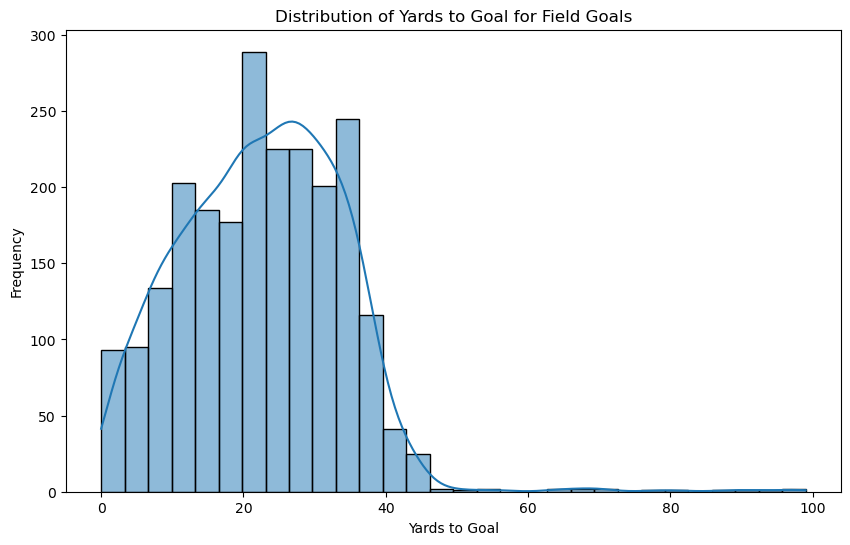

In [71]:
# plot the distirbutoin of yards_to_Goal when was_field_goal is True
plt.figure(figsize=(10, 6))
sns.histplot(plays.query('play_decision == "field_goal"')['yards_to_goal'], bins=30, kde=True)
plt.title('Distribution of Yards to Goal for Field Goals')
plt.xlabel('Yards to Goal')
plt.ylabel('Frequency')
plt.show() 

In [72]:
rolling_stats_last6.columns

Index(['game_id', 'season', 'week', 'season_type', 'team_id', 'team',
       'last6_rush_att', 'last6_rush_yds', 'last6_pass_att', 'last6_pass_yds',
       'last6_kicking_pts', 'last6_offense_passing_plays_ppa',
       'last6_offense_passing_plays_success_rate',
       'last6_offense_passing_plays_explosiveness',
       'last6_offense_rushing_plays_ppa',
       'last6_offense_rushing_plays_success_rate',
       'last6_offense_rushing_plays_explosiveness',
       'last6_defense_passing_plays_ppa',
       'last6_defense_passing_plays_success_rate',
       'last6_defense_passing_plays_explosiveness',
       'last6_defense_rushing_plays_ppa',
       'last6_defense_rushing_plays_success_rate',
       'last6_defense_rushing_plays_explosiveness', 'last6_pass_to_rush_ratio',
       'last6_yards_per_rush', 'last6_yards_per_pass'],
      dtype='object')

In [92]:
cols = [
    'offense_timeouts', 'defense_timeouts', 'yards_to_goal', 'down', 'distance',
    'score_diff', 'seconds_remaining', 'pct_game_played', 'diff_time_ratio', 'play_decision',
    'is_redzone', 'is_goal_to_go', 'is_two_minute_drill',
    'is_blowout', 'field_goal_range', 'down_x_distance',
    'offense_elo', 'defense_elo',
    'offense_last6_kicking_pts', 'offense_last6_pass_to_rush_ratio',
    'offense_last6_yards_per_rush', 'offense_last6_yards_per_pass',
    'last6_offense_passing_plays_ppa', 'last6_offense_passing_plays_success_rate',
    'last6_offense_passing_plays_explosiveness',
    'last6_offense_rushing_plays_ppa', 'last6_offense_rushing_plays_success_rate',
    'last6_offense_rushing_plays_explosiveness',
    'last6_defense_passing_plays_ppa', 'last6_defense_passing_plays_success_rate',
    'last6_defense_passing_plays_explosiveness',
    'last6_defense_rushing_plays_ppa', 'last6_defense_rushing_plays_success_rate',
    'last6_defense_rushing_plays_explosiveness',
    'offense_last6_kicking_pts', 'offense_last6_pass_to_rush_ratio',
    'offense_last6_yards_per_rush', 'offense_last6_yards_per_pass',
    'last12_kicking_pts', 'last12_pass_to_rush_ratio',
    'last12_yards_per_rush', 'last12_yards_per_pass',
    'last12_offense_passing_plays_ppa', 'last12_offense_passing_plays_success_rate',
    'last12_offense_passing_plays_explosiveness',
    'last12_offense_rushing_plays_ppa', 'last12_offense_rushing_plays_success_rate',
    'last12_offense_rushing_plays_explosiveness',
    'last12_defense_passing_plays_ppa', 'last12_defense_passing_plays_success_rate',
    'last12_defense_passing_plays_explosiveness',
    'last12_defense_rushing_plays_ppa', 'last12_defense_rushing_plays_success_rate',
    'last12_defense_rushing_plays_explosiveness',
]
decisions = (
    plays
    .assign(
        offense_timeouts = lambda x: np.where(x.offense_timeouts == -1, 0, x.offense_timeouts),
        defense_timeouts = lambda x: np.where(x.defense_timeouts == -1, 0, x.defense_timeouts)
    )
    .query('0 < yards_to_goal < 100 and 0 < distance < 100 and '
           '0 <= offense_timeouts <= 3 and 0 <= defense_timeouts <= 3 and '
           '0 <= clock_minutes <= 15 and 0 <= clock_seconds < 59')
    .assign(
        score_diff = lambda x: x['offense_score'] - x['defense_score'],
        seconds_remaining = lambda x: (
            (4 * 15 * 60) - # total game time in seconds
            ((x['period'] - 1) * 15 * 60) - # elapsed quarters in seconds
            (15 * 60 - (x['clock_minutes'] * 60 + x['clock_seconds'])) 
        )
    )
    .assign(
        pct_game_played = lambda x: (4 * 15 * 60 - x['seconds_remaining']) / (4 * 15 * 60),
        diff_time_ratio = lambda x: x['score_diff'] * np.exp(4 * (3600 - x['seconds_remaining']) / 3600),
        is_redzone=lambda x: (x['yards_to_goal'] <= 20).astype(int),
        is_goal_to_go=lambda x: (x['yards_to_goal'] <= x['distance']).astype(int),
        is_two_minute_drill=lambda x: (
            (x['seconds_remaining'] <= 120) |
            ((x['period'] == 2) & (x['seconds_remaining'] <= 1920))
        ).astype(int),
        is_blowout=lambda x: (x['score_diff'] >= 21).astype(int),
        field_goal_range=lambda x: (x['yards_to_goal'] <= 40).astype(int), # 57 yard fg max
        down_x_distance=lambda x: x['down'] * x['distance'],
    )
    .assign(
        was_pass=lambda x: (x['play_decision'] == 'pass').astype(int),
        was_run=lambda x: (x['play_decision'] == 'run').astype(int),
        was_field_goal=lambda x: (x['play_decision'] == 'field_goal').astype(int),
        was_kneel=lambda x: (x['play_decision'] == 'kneel').astype(int)
    )
)
decisions = (
    decisions[
        ((decisions['was_field_goal'] == 1) & (decisions['yards_to_goal'] <= 50)) |
        (decisions['was_field_goal'] == 0)
    ]
    .merge(
        games[['id','season','week']].rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'elo']]
            .rename(columns={
                'team': 'offense',
                'elo': 'offense_elo'
            }),
        left_on=['season', 'week', 'offense'],
        right_on=['season', 'week', 'offense'],
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'elo']]
            .rename(columns={
                'team': 'defense',
                'elo': 'defense_elo'
            }),
        left_on=['season', 'week', 'defense'],
        right_on=['season', 'week', 'defense'],
        how='left'
    )
    .merge(
        rolling_stats_last6[['game_id', 'team',
            'last6_kicking_pts', ''
            'last6_offense_passing_plays_ppa',
            'last6_offense_passing_plays_success_rate',
            'last6_offense_passing_plays_explosiveness',
            'last6_offense_rushing_plays_ppa',
            'last6_offense_rushing_plays_success_rate',
            'last6_offense_rushing_plays_explosiveness',
            'last6_defense_passing_plays_ppa',
            'last6_defense_passing_plays_success_rate',
            'last6_defense_passing_plays_explosiveness',
            'last6_defense_rushing_plays_ppa',
            'last6_defense_rushing_plays_success_rate',
            'last6_defense_rushing_plays_explosiveness', 
            'last6_pass_to_rush_ratio',
            'last6_yards_per_rush', 
            'last6_yards_per_pass']]
            .rename(columns={
                'team': 'offense',
                'last6_kicking_pts': 'offense_last6_kicking_pts',
                'last6_pass_to_rush_ratio': 'offense_last6_pass_to_rush_ratio',
                'last6_yards_per_rush': 'offense_last6_yards_per_rush',
                'last6_yards_per_pass': 'offense_last6_yards_per_pass'
            }),
        on=['game_id', 'offense'],
        how='left'
    )
    .merge(
        rolling_stats_last12[['game_id', 'team',
            'last12_kicking_pts',
            'last12_offense_passing_plays_ppa',
            'last12_offense_passing_plays_success_rate',
            'last12_offense_passing_plays_explosiveness',  
            'last12_offense_rushing_plays_ppa',
            'last12_offense_rushing_plays_success_rate',
            'last12_offense_rushing_plays_explosiveness',
            'last12_defense_passing_plays_ppa',
            'last12_defense_passing_plays_success_rate',
            'last12_defense_passing_plays_explosiveness',
            'last12_defense_rushing_plays_ppa',
            'last12_defense_rushing_plays_success_rate',
            'last12_defense_rushing_plays_explosiveness',
            'last12_pass_to_rush_ratio',
            'last12_yards_per_rush',
            'last12_yards_per_pass']]
            .rename(columns={
                'team': 'offense',
                'last6_kicking_pts': 'offense_last12_kicking_pts',
                'last6_pass_to_rush_ratio': 'offense_last12_pass_to_rush_ratio',
                'last6_yards_per_rush': 'offense_last12_yards_per_rush',
                'last6_yards_per_pass': 'offense_last12_yards_per_pass'
            }),
        on=['game_id', 'offense'],
        how='left'
    )
    .dropna(subset=['offense_last6_pass_to_rush_ratio'], ignore_index=True)
    [['season','week','offense','defense'] + cols + ['was_pass', 'was_run', 'was_field_goal', 'was_kneel']]
)
decisions.head()

,season,week,offense,defense,offense_timeouts,defense_timeouts,yards_to_goal,down,distance,score_diff,seconds_remaining,pct_game_played,diff_time_ratio,play_decision,is_redzone,is_goal_to_go,is_two_minute_drill,is_blowout,field_goal_range,down_x_distance,offense_elo,defense_elo,offense_last6_kicking_pts,offense_last6_pass_to_rush_ratio,offense_last6_yards_per_rush,offense_last6_yards_per_pass,last6_offense_passing_plays_ppa,last6_offense_passing_plays_success_rate,last6_offense_passing_plays_explosiveness,last6_offense_rushing_plays_ppa,last6_offense_rushing_plays_success_rate,last6_offense_rushing_plays_explosiveness,last6_defense_passing_plays_ppa,last6_defense_passing_plays_success_rate,last6_defense_passing_plays_explosiveness,last6_defense_rushing_plays_ppa,last6_defense_rushing_plays_success_rate,last6_defense_rushing_plays_explosiveness,offense_last6_kicking_pts,offense_last6_pass_to_rush_ratio,offense_last6_yards_per_rush,offense_last6_yards_per_pass,last12_kicking_pts,last12_pass_to_rush_ratio,last12_yards_per_rush,last12_yards_per_pass,last12_offense_passing_plays_ppa,last12_offense_passing_plays_success_rate,last12_offense_passing_plays_explosiveness,last12_offense_rushing_plays_ppa,last12_offense_rushing_plays_success_rate,last12_offense_rushing_plays_explosiveness,last12_defense_passing_plays_ppa,last12_defense_passing_plays_success_rate,last12_defense_passing_plays_explosiveness,last12_defense_rushing_plays_ppa,last12_defense_rushing_plays_success_rate,last12_defense_rushing_plays_explosiveness,was_pass,was_run,was_field_goal,was_kneel
0,2013,1,Maryland,Marshall,0.0,2.0,72,3,10,-11,81,0.977500,-548.888472,pass,0,0,1,0,0,30,1921.246102,1703.121251,15.0,0.76,3.9,4.6,-0.147,0.338,1.419,0.039,0.38,0.936,0.636,0.543,1.708,0.216,0.497,1.008,15.0,0.76,3.9,4.6,55.0,0.823,4.5,6.4,0.1,0.364,1.619,0.083,0.383,1.106,0.597,0.519,1.732,0.17,0.505,0.88,1,0,0,0
1,2013,1,Maryland,Marshall,0.0,2.0,72,2,10,-11,91,0.974722,-542.823468,pass,0,0,1,0,0,20,1921.246102,1703.121251,15.0,0.76,3.9,4.6,-0.147,0.338,1.419,0.039,0.38,0.936,0.636,0.543,1.708,0.216,0.497,1.008,15.0,0.76,3.9,4.6,55.0,0.823,4.5,6.4,0.1,0.364,1.619,0.083,0.383,1.106,0.597,0.519,1.732,0.17,0.505,0.88,1,0,0,0
2,2013,1,Maryland,Marshall,0.0,2.0,72,1,10,-11,95,0.973611,-540.416272,pass,0,0,1,0,0,10,1921.246102,1703.121251,15.0,0.76,3.9,4.6,-0.147,0.338,1.419,0.039,0.38,0.936,0.636,0.543,1.708,0.216,0.497,1.008,15.0,0.76,3.9,4.6,55.0,0.823,4.5,6.4,0.1,0.364,1.619,0.083,0.383,1.106,0.597,0.519,1.732,0.17,0.505,0.88,1,0,0,0
3,2013,1,Maryland,Marshall,3.0,3.0,37,1,10,-7,2940,0.183333,-14.574064,run,0,0,0,0,1,10,1921.246102,1703.121251,15.0,0.76,3.9,4.6,-0.147,0.338,1.419,0.039,0.38,0.936,0.636,0.543,1.708,0.216,0.497,1.008,15.0,0.76,3.9,4.6,55.0,0.823,4.5,6.4,0.1,0.364,1.619,0.083,0.383,1.106,0.597,0.519,1.732,0.17,0.505,0.88,0,1,0,0
4,2013,1,Maryland,Marshall,3.0,3.0,51,2,6,-7,2965,0.176389,-14.174799,pass,0,0,0,0,0,12,1921.246102,1703.121251,15.0,0.76,3.9,4.6,-0.147,0.338,1.419,0.039,0.38,0.936,0.636,0.543,1.708,0.216,0.497,1.008,15.0,0.76,3.9,4.6,55.0,0.823,4.5,6.4,0.1,0.364,1.619,0.083,0.383,1.106,0.597,0.519,1.732,0.17,0.505,0.88,1,0,0,0


In [95]:
feature_names = [
    'offense_timeouts',
    'defense_timeouts', 
    'yards_to_goal', 
    'down', 
    'distance', 
    'score_diff',
    'seconds_remaining', 
    'pct_game_played', 
    'diff_time_ratio',
    'is_redzone', 
    'is_goal_to_go', 
    'is_two_minute_drill',
    'is_blowout', 
    'field_goal_range', 
    'down_x_distance', 
    'offense_elo',
    'defense_elo', 
    'offense_last6_kicking_pts',
    'offense_last6_pass_to_rush_ratio', 
    'offense_last6_yards_per_rush',
    'offense_last6_yards_per_pass', 
    'last6_offense_passing_plays_ppa',
    'last6_offense_passing_plays_success_rate',
    # 'last6_offense_passing_plays_explosiveness',
    'last6_offense_rushing_plays_ppa',
    'last6_offense_rushing_plays_success_rate',
    # 'last6_offense_rushing_plays_explosiveness',
    'last6_defense_passing_plays_ppa',
    'last6_defense_passing_plays_success_rate',
    # 'last6_defense_passing_plays_explosiveness',
    'last6_defense_rushing_plays_ppa',
    'last6_defense_rushing_plays_success_rate',
    # 'last6_defense_rushing_plays_explosiveness',
    'last12_kicking_pts',
    'last12_pass_to_rush_ratio',
    'last12_yards_per_rush',
    'last12_yards_per_pass',
    'last12_offense_passing_plays_ppa',
    'last12_offense_passing_plays_success_rate',
    # 'last12_offense_passing_plays_explosiveness',
    'last12_offense_rushing_plays_ppa',
    'last12_offense_rushing_plays_success_rate',
    # 'last12_offense_rushing_plays_explosiveness',
    'last12_defense_passing_plays_ppa',
    'last12_defense_passing_plays_success_rate',
    # 'last12_defense_passing_plays_explosiveness',
    'last12_defense_rushing_plays_ppa',
    'last12_defense_rushing_plays_success_rate',
    # 'last12_defense_rushing_plays_explosiveness'
]

# Encode play_decision: pass -> 0, run -> 1, field_goal -> 2, kneel -> 3
if decisions.play_decision.dtype == 'object':
    decisions['play_decision'] = decisions['play_decision'].map({
        'pass': 0,
        'run': 1,
        'field_goal': 2,
        'kneel': 3
    })

data = decisions[feature_names + ['play_decision']].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data['play_decision']
)
test_x, test_y = test_data[feature_names], test_data['play_decision']

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[feature_names], 
    train_data['play_decision'], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data['play_decision']
)

In [102]:
# correlation heatmap
plt.figure(figsize=(50, 40))
sns.heatmap(
    decisions[feature_names + ['was_pass', 'was_run', 'was_field_goal', 'was_kneel']].corr(),
    annot=True, 
    fmt=".3f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

KeyboardInterrupt: 

In [105]:
train_x.isna().sum()

offense_timeouts                                  0
defense_timeouts                                  0
yards_to_goal                                     0
down                                              0
distance                                          0
score_diff                                        0
seconds_remaining                                 0
pct_game_played                                   0
diff_time_ratio                                   0
is_redzone                                        0
is_goal_to_go                                     0
is_two_minute_drill                               0
is_blowout                                        0
field_goal_range                                  0
down_x_distance                                   0
offense_elo                                       0
defense_elo                                       0
offense_last6_kicking_pts                         0
offense_last6_kicking_pts                         0
offense_last

In [ ]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "multi:softprob",  # Changed for multiclass
        "num_class": 4,  # Added for multiclass
        "eval_metric": "mlogloss",  # Changed to multiclass logloss
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
    
    # Calculate multiclass log loss
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="multiclass_optimization",
    direction="minimize", 
    load_if_exists=True,
    sampler=sampler
)
study.optimize(
    lambda trial: objective(trial, dtrain, dvalid), 
    n_trials=50,
    show_progress_bar=True
)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'multi:softprob',
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'booster': 'gbtree',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

def evaluate_multiclass(y_true, y_pred):
    # Calculate various multiclass metrics
    y_pred_class = np.argmax(y_pred, axis=1)
    
    print(f"Multiclass log loss: {log_loss(y_true, y_pred):0.3f}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred_class):0.3f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_class))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred_class))
    
    # Calculate ROC AUC if binary (for each class)
    if len(np.unique(y_true)) <= 2:
        print(f"\nROC AUC: {roc_auc_score(y_true, y_pred[:, 1]):0.3f}")
    else:
        try:
            print("\nROC AUC (OvR):")
            for i in range(4):  # For each class
                print(f"Class {i}: {roc_auc_score((y_true == i).astype(int), y_pred[:, i]):0.3f}")
            print(f"Macro average: {roc_auc_score(y_true, y_pred, multi_class='ovr', average='macro'):0.3f}")
        except:
            print("Couldn't calculate ROC AUC for all classes")

# Evaluate on train set
print("\n=== Train Set ===")
train_preds = final_model.predict(dtrain)
evaluate_multiclass(train_y, train_preds)

# Evaluate on validation set
print("\n=== Validation Set ===")
valid_preds = final_model.predict(dvalid)
evaluate_multiclass(valid_y, valid_preds)

# Evaluate on test set
print("\n=== Test Set ===")
dtest = xgb.DMatrix(test_x, label=test_y)
test_preds = final_model.predict(dtest)
evaluate_multiclass(test_y, test_preds)

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [44]:
from sklearn.dummy import DummyClassifier

# Fit a dummy classifier that always predicts class probabilities
dummy = DummyClassifier(strategy="prior")
dummy.fit(train_x, train_y)  # train_y should be encoded (0, 1, 2, 3)

# Evaluate on test set
dummy_probs = dummy.predict_proba(test_x)
dummy_log_loss = log_loss(test_y, dummy_probs)
print(f"Dummy classifier log loss: {dummy_log_loss:0.3f}")

Dummy classifier log loss: 0.711


In [54]:
n_row = 10000  # Reduced for memory safety
chunk_size = 5000  # Smaller chunks
background = train_data[feature_names].iloc[:n_row]

# Initialize explainer - critical fix for multiclass
explainer = shap.TreeExplainer(final_model, background, feature_perturbation="interventional")

# Process in chunks
shap_values_list = []
for i in tqdm(range(0, n_row, chunk_size)):
    chunk = background.iloc[i:i+chunk_size]
    shap_values_chunk = explainer.shap_values(chunk)
    shap_values_list.append(shap_values_chunk)

# Combine chunks - now returns list of arrays [class1, class2, class3, class4]
shap_values = [np.concatenate([sv[i] for sv in shap_values_list], axis=0) 
               for i in range(4)]  # For 4 classes

# Class names matching your encoding
class_names = ['Pass', 'Run', 'FG Attempt', 'QB Kneel']

# Plot each class
for class_idx in range(4):
    print(f"\n=== SHAP Summary for {class_names[class_idx]} ===")
    shap.summary_plot(
        shap_values[class_idx],  # SHAP values for this class
        background,
        plot_type="dot",
        max_display=15,
        show=False
    )
    plt.title(f"Feature Importance: {class_names[class_idx]}")
    plt.show()

100%|██████████| 5/5 [2:09:52<00:00, 1558.52s/it]1]        


=== SHAP Summary for Pass ===



/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_32194/88455721.py:30: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

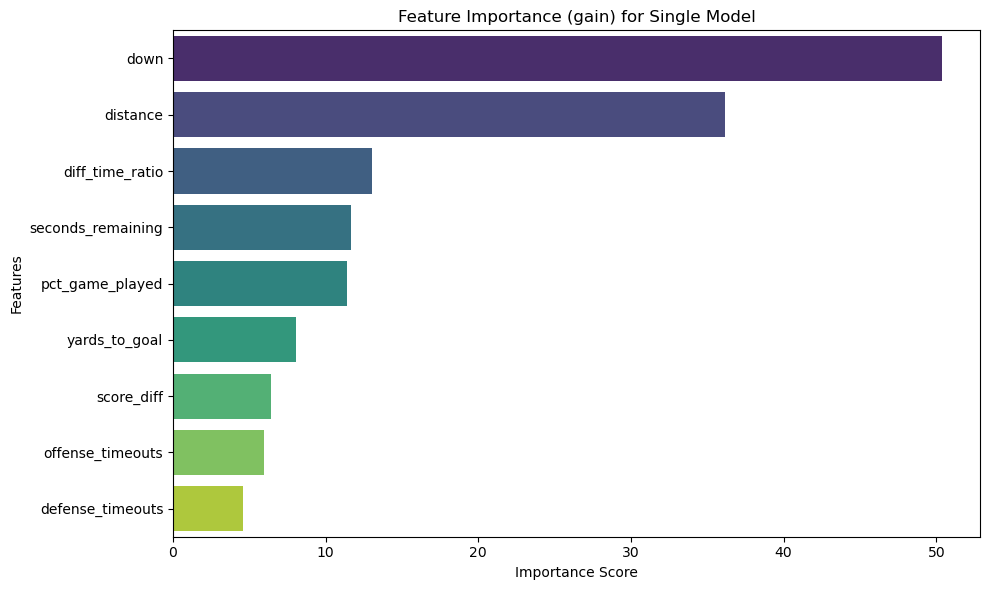

In [46]:
importance_type = "gain"  # Options: "gain", "weight", "cover"

# Get feature importance for a single model
importance = final_model.get_score(importance_type=importance_type)

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    palette="viridis", 
    hue="Feature", 
    dodge=False
)
plt.title(f"Feature Importance ({importance_type}) for Single Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

In [47]:
class_probas = final_model.predict(xgb.DMatrix(decisions[feature_names]))

decisions['pass_proba'] = class_probas[:, 0]  # Class 0: Pass
decisions['run_proba'] = class_probas[:, 1]    # Class 1: Run
decisions['fg_proba'] = class_probas[:, 2]     # Class 2: FG
decisions['qb_kneel_proba'] = class_probas[:, 3]  # Class 3: QB Kneel

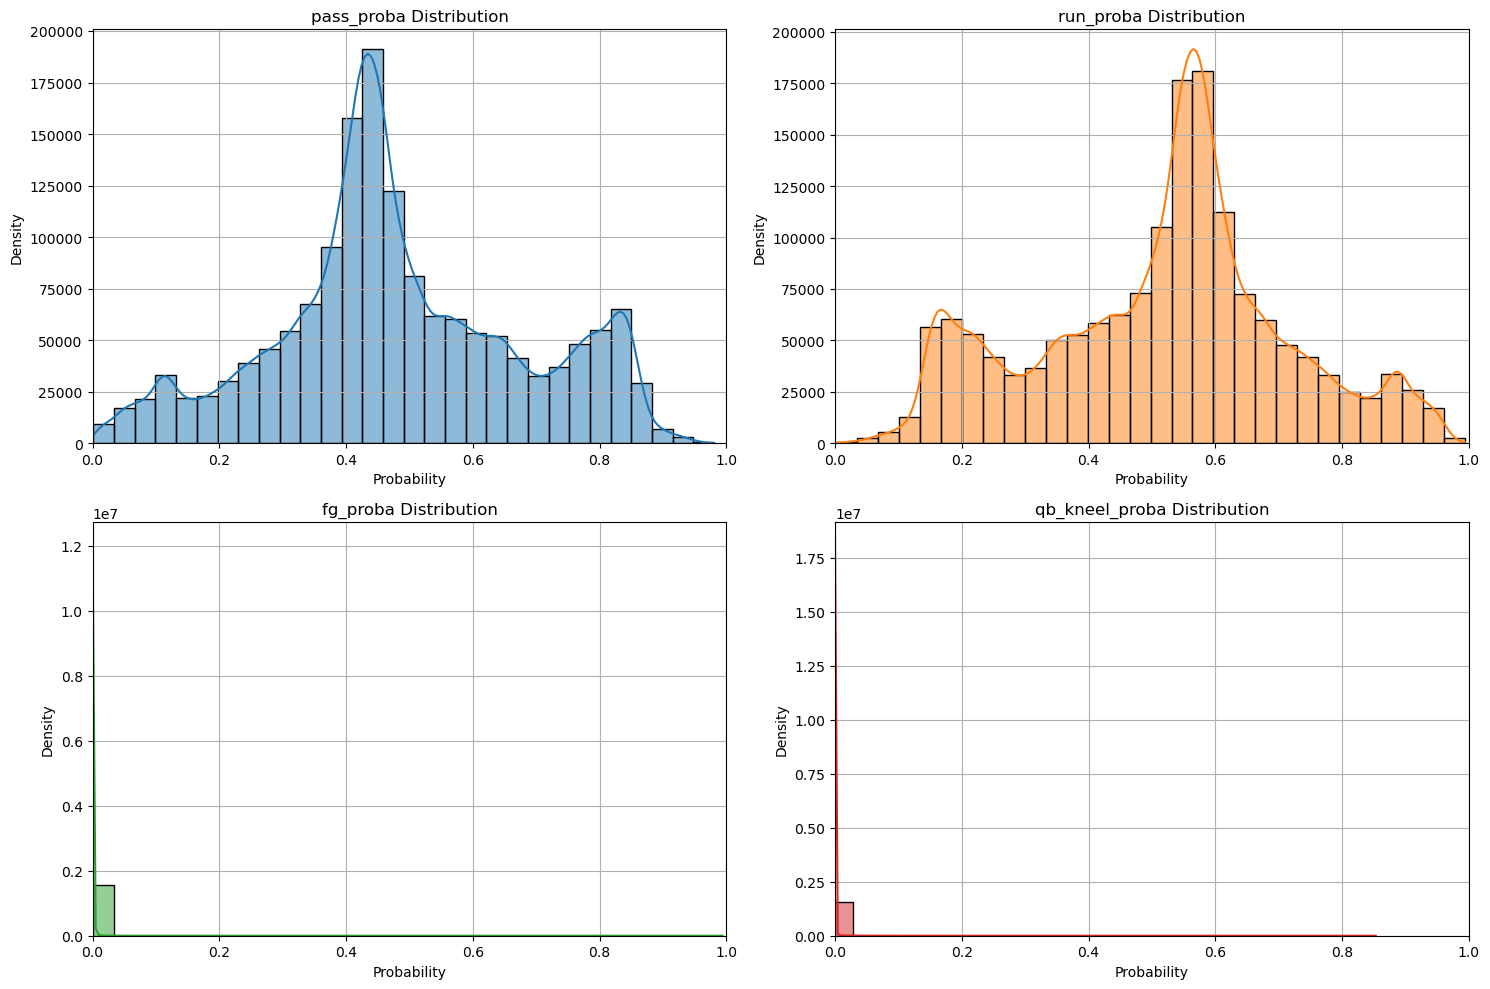

In [48]:
def plot_multiclass_probas(df, proba_cols=['pass_proba', 'run_proba', 'fg_proba', 'qb_kneel_proba']):
    plt.figure(figsize=(15, 10))
    
    for i, col in enumerate(proba_cols, 1):
        plt.subplot(2, 2, i)  # 2x2 grid of plots
        sns.histplot(df[col], bins=30, kde=True, color=f'C{i-1}')
        plt.title(f'{col} Distribution')
        plt.xlabel('Probability')
        plt.ylabel('Density')
        plt.grid(True)
        plt.xlim(0, 1)
    
    plt.tight_layout()
    plt.show()

plot_multiclass_probas(decisions)

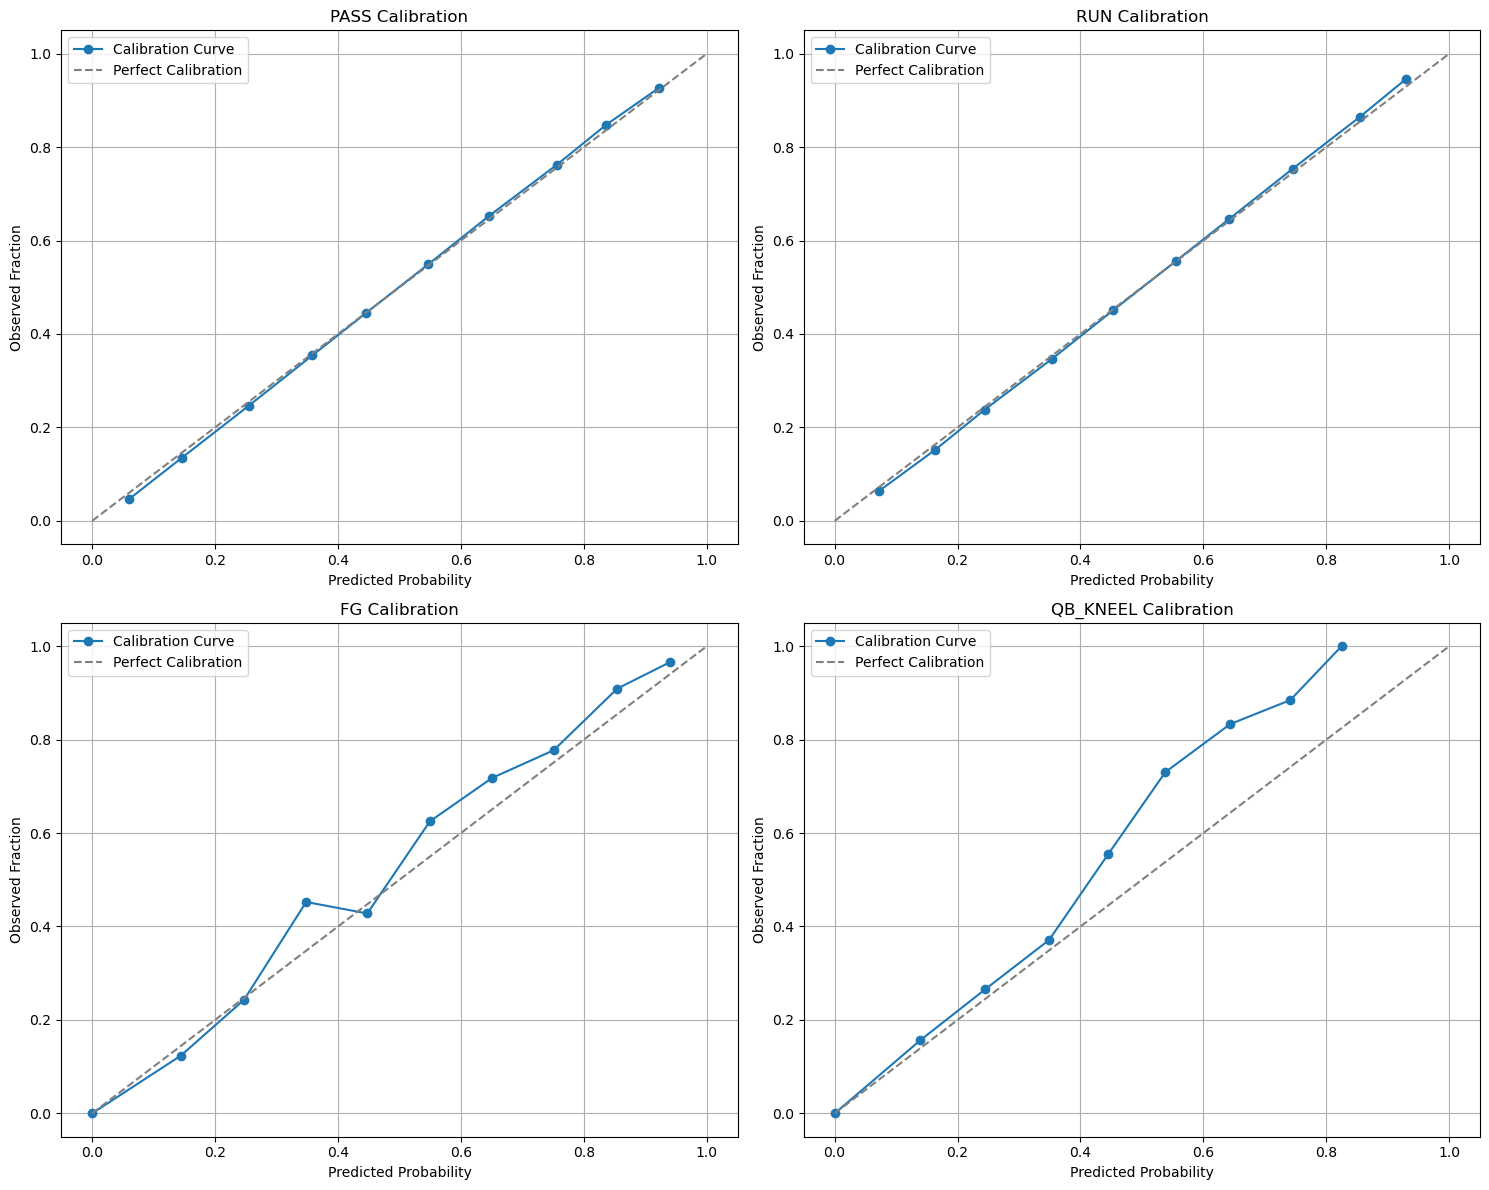

In [52]:
def plot_multiclass_calibration(df, proba_cols, actual_cols, bins=30):
    """
    Plots calibration curves for multiple classes in subplots.
    
    Args:
        df: DataFrame containing predicted probabilities and actual outcomes
        proba_cols: List of predicted probability columns (e.g., ['pass_proba', 'run_proba', ...])
        actual_cols: List of actual outcome columns (should be binary 0/1 for each class)
        bins: Number of bins for calibration
    """
    plt.figure(figsize=(15, 12))
    
    for i, (proba_col, actual_col) in enumerate(zip(proba_cols, actual_cols), 1):
        plt.subplot(2, 2, i)
        
        df['proba_bin'] = pd.cut(df[proba_col], 
                                bins=np.linspace(0, 1, bins + 1),
                                labels=False, 
                                include_lowest=True)
        
        calibration = df.groupby('proba_bin').agg(
            predicted_proba=(proba_col, 'mean'),
            actual_proba=(actual_col, 'mean'),
            count=(proba_col, 'size')
        ).reset_index()
        
        plt.plot(calibration['predicted_proba'], calibration['actual_proba'], 
                'o-', label='Calibration Curve')
        plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')
        
        plt.title(f'{proba_col.replace("_proba", "").upper()} Calibration')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Observed Fraction')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_multiclass_calibration(
    df=decisions,
    proba_cols=['pass_proba', 'run_proba', 'fg_proba', 'qb_kneel_proba'],
    actual_cols=['was_pass', 'was_run', 'was_field_goal', 'was_kneel'],
    bins=10
)